In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from constants import MODEL1, MODEL2, MODEL3
from model import Autoencoder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import time

In [37]:
train_X = pd.read_csv("data/train_X.csv")
X_test_scaled = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")

print(train_X.shape[1])  
print(X_test_scaled.shape[1]) 

train_tensor = torch.tensor(train_X.values, dtype=torch.float32)
train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
print(len(train_loader.dataset))  # Should be ~12,267,408



18
18
12267408


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL2 = Autoencoder(input_dim=18, hidden_dims=[32, 16, 8])
model = MODEL2.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

num_epochs = 20

In [39]:
losses = []
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, Time: {elapsed:.2f}s")

Epoch 1/20, Loss: 0.160548, Time: 42.04s
Epoch 2/20, Loss: 0.148166, Time: 41.75s
Epoch 3/20, Loss: 0.147973, Time: 41.95s
Epoch 4/20, Loss: 0.147889, Time: 41.87s
Epoch 5/20, Loss: 0.147818, Time: 41.70s
Epoch 6/20, Loss: 0.147779, Time: 42.12s
Epoch 7/20, Loss: 0.147752, Time: 40.98s
Epoch 8/20, Loss: 0.147643, Time: 40.50s
Epoch 9/20, Loss: 0.147509, Time: 40.73s
Epoch 10/20, Loss: 0.147405, Time: 40.49s
Epoch 11/20, Loss: 0.147335, Time: 41.02s
Epoch 12/20, Loss: 0.147301, Time: 40.77s
Epoch 13/20, Loss: 0.147272, Time: 41.05s
Epoch 14/20, Loss: 0.147249, Time: 40.52s
Epoch 15/20, Loss: 0.147235, Time: 40.64s
Epoch 16/20, Loss: 0.147191, Time: 40.67s
Epoch 17/20, Loss: 0.147128, Time: 40.32s
Epoch 18/20, Loss: 0.147115, Time: 40.66s
Epoch 19/20, Loss: 0.147107, Time: 40.59s
Epoch 20/20, Loss: 0.147099, Time: 40.39s


In [40]:
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_tensor).cpu().numpy()

reconstruction_errors = np.mean((X_test_scaled - reconstructions) ** 2, axis=1)
X_test_scaled = np.nan_to_num(X_test_scaled)
reconstructions = np.nan_to_num(reconstructions)

reconstruction_errors = np.mean((X_test_scaled - reconstructions) ** 2, axis=1)

threshold = np.percentile(reconstruction_errors, 85)

y_pred = (reconstruction_errors > threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


Threshold: 0.000228
Precision: 0.4996
Recall:    0.1499
F1 Score:  0.2306
Confusion Matrix:
[[2606470  460383]
 [2607180  459673]]


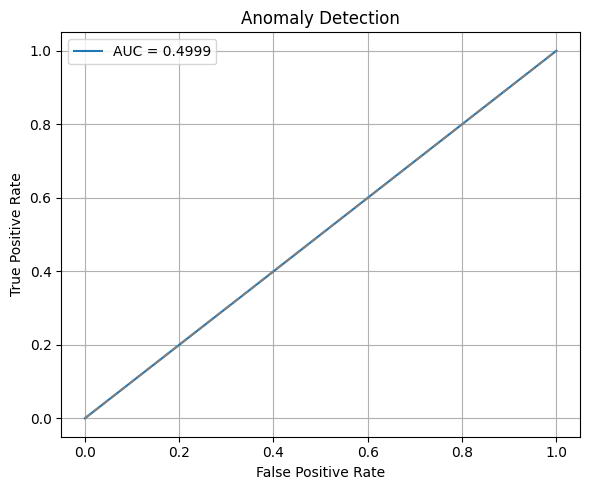

In [41]:
print(f"\nThreshold: {threshold:.6f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Anomaly Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

